# Installation and import of libraries

In [18]:
!pip install rdkit
!pip install chembl_webresource_client

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from chembl_webresource_client.new_client import new_client

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from scipy.spatial.distance import pdist, cdist, squareform

from tqdm import tqdm

PandasTools.RenderImagesInAllDataFrames(images=True)

# Getting bioactivity data from ChEMBL

In [2]:
bioactivities_api = new_client.activity
compounds_api = new_client.molecule

information_of_interest=["activity_id","pref_name", "assay_chembl_id","assay_description",
                         "assay_type","molecule_chembl_id","type","standard_units","relation",
                         "standard_value","target_chembl_id","target_organism",'document_chembl_id', 'data_validity_comment']

# ChEMBL ID for DNMT1 is CHEMBL1993

bioactivities = bioactivities_api.filter(
    target_chembl_id="CHEMBL1993", type="IC50", assay_type="B"
).only(information_of_interest)

print(f"Length and type of bioactivities object: {len(bioactivities)},  {type(bioactivities)}")

Length and type of bioactivities object: 310,  <class 'chembl_webresource_client.query_set.QuerySet'>


In [3]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head(3)

DataFrame shape: (311, 15)


,activity_id,assay_chembl_id,assay_description,assay_type,data_validity_comment,document_chembl_id,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
1,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
2,1671886,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL383475,=,nM,50000.0,CHEMBL1993,Homo sapiens,IC50,uM,50.0


In [4]:
# Remove entries without a bioactivity value
bioactivities_df = bioactivities_df.dropna(subset=["standard_value"]).reset_index(drop=True)
bioactivities_df.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,data_validity_comment,document_chembl_id,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
1,1671884,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL382617,=,nM,100000.0,CHEMBL1993,Homo sapiens,IC50,uM,100.0
2,1671886,CHEMBL862798,Inhibitory activity against DNA methyl transfe...,B,None,CHEMBL1147744,CHEMBL383475,=,nM,50000.0,CHEMBL1993,Homo sapiens,IC50,uM,50.0


In [5]:
# Check possible relations
bioactivities_df["relation"].value_counts()

relation
=     263
>      31
>=      1
Name: count, dtype: int64

In [6]:
# Custom labeling of compounds

def label_data(row):
  if row["relation"] == "=":
    if float(row["standard_value"]) <= 10000:
      return 1 # Active
    else:
      return 0 # Inactive
  else:
    if float(row["standard_value"]) >= 10000:
      return 0 # Inactive
    else:
      return 2 # Inconclusive

# Apply custom function
bioactivities_df["label"] = bioactivities_df.apply(label_data, axis=1)
# Remove inconclusive data
bioactivities_df = bioactivities_df[bioactivities_df["label"] != 2].reset_index(drop=True)
print(bioactivities_df.shape)

(287, 16)


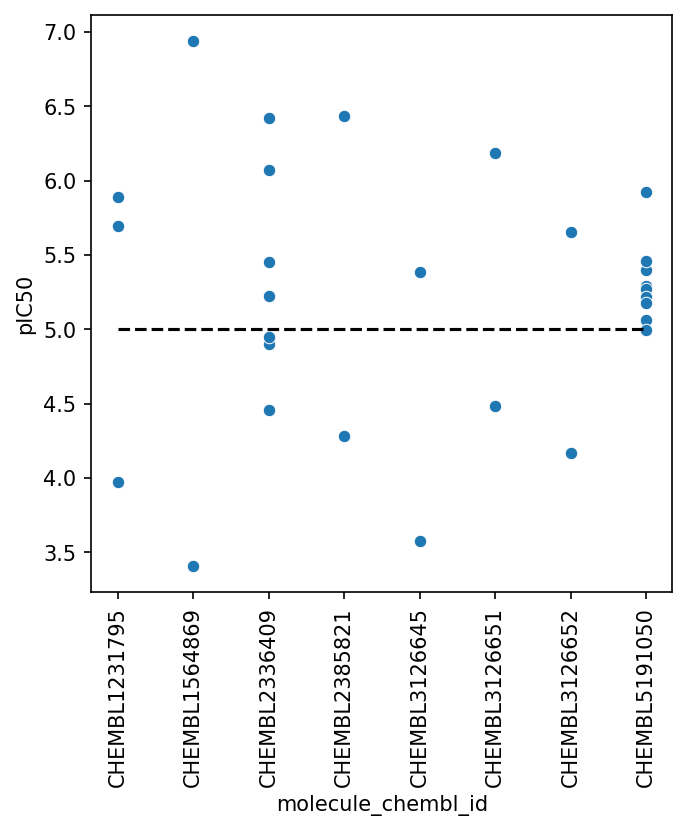

In [7]:
# Obtain compounds with contradictory labels
undetermined = []
for name, group in bioactivities_df.groupby("molecule_chembl_id"):
  if group.shape[0] > 1 and group["label"].nunique() > 1:
    undetermined.append(name)
undetermined

# Convert standard value to pIC50
bioactivities_df["standard_value"] = bioactivities_df["standard_value"].apply(float)
bioactivities_df["pIC50"] = bioactivities_df["standard_value"].apply(lambda x: 9 - math.log10(x))

# Plot data points with contradictory labels
plt.figure(dpi=150, figsize=(5,5))
sns.scatterplot(x="molecule_chembl_id", y="pIC50", data=bioactivities_df[bioactivities_df["molecule_chembl_id"].isin(undetermined)].sort_values("molecule_chembl_id"))
plt.plot([0,7], [5,5], "k--")
plt.xticks(rotation=90)
plt.show()

In [8]:
# Compound CHEMBL5191050 will be considered as active, the others were discarded
undetermined.remove('CHEMBL5191050')
bioactivities_df = bioactivities_df[bioactivities_df["molecule_chembl_id"].isin(undetermined) == False].reset_index(drop=True)
bioactivities_df = bioactivities_df.sort_values("pIC50", ascending=False).drop_duplicates("molecule_chembl_id",  keep="first").reset_index(drop=True)
print(f"DataFrame shape afther delete duplicate compounds: {bioactivities_df.shape}")


DataFrame shape afther delete duplicate compounds: (228, 17)


In [9]:
# Rename columns
bioactivities_df.rename(
    columns={"standard_value": "IC50",
             "standard_units": "std_units",
             "units": "Units"}, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,data_validity_comment,document_chembl_id,molecule_chembl_id,relation,std_units,IC50,target_chembl_id,target_organism,type,Units,value,label,pIC50
0,19476082,CHEMBL4479553,Inhibition of DNMT1 (unknown origin),B,None,CHEMBL4477246,CHEMBL3087498,=,nM,0.3,CHEMBL1993,Homo sapiens,IC50,nM,0.3,1,9.522879
1,19476083,CHEMBL4479553,Inhibition of DNMT1 (unknown origin),B,None,CHEMBL4477246,CHEMBL2171169,=,nM,2.9,CHEMBL1993,Homo sapiens,IC50,nM,2.9,1,8.537602
2,10941665,CHEMBL2050446,Inhibition of semi-purified DNMT1,B,None,CHEMBL2046381,CHEMBL83747,=,nM,18.6,CHEMBL1993,Homo sapiens,IC50,nM,18.6,1,7.730487
3,18532350,CHEMBL4195563,Inhibition of human DNMT1 using polydeoxyinosi...,B,None,CHEMBL4190398,CHEMBL4215326,=,nM,21.0,CHEMBL1993,Homo sapiens,IC50,nM,21.0,1,7.677781
4,18337673,CHEMBL4137467,Inhibition of human DNMT1 using polydeoxyinosi...,B,None,CHEMBL4130634,CHEMBL1201129,=,nM,30.0,CHEMBL1993,Homo sapiens,IC50,nM,30.0,1,7.522879


In [57]:
# Donwload compounds data from ChEMBL

information_of_interest = ["molecule_chembl_id", "molecule_structures", "max_phase"]
compounds_provider_a= compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])).only(information_of_interest)
compounds_a = list(tqdm(compounds_provider_a))
#Note: in the molecule_structures segment we can obtain the canonical SMILES.
compounds_df_a = pd.DataFrame.from_records(compounds_a)
compounds_df_a["smiles"] = compounds_df_a["molecule_structures"].apply(lambda x: x["canonical_smiles"])
compounds_df_a.drop("molecule_structures", axis=1, inplace=True)
compounds_df_a.reset_index(drop=True, inplace=True)

print(f"DataFrame shape: {compounds_df_a.shape}")
compounds_df_a.head(3)

100%|██████████| 228/228 [00:12<00:00, 17.87it/s]

DataFrame shape: (228, 3)


,max_phase,molecule_chembl_id,smiles
0,2.0,CHEMBL44,O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12
1,4.0,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO
2,4.0,CHEMBL640,CCN(CC)CCNC(=O)c1ccc(N)cc1


In [59]:
# Merge compounds and bioactivity data
data = pd.merge(bioactivities_df[['document_chembl_id', 'molecule_chembl_id', 'relation', 'std_units','IC50', 'label', 'pIC50']], compounds_df_a)
print(f"Dataset with {data.shape[0]} entries.") # This changed with the latest release if ChEMBL
data.head()

Dataset with 228 entries.


,document_chembl_id,molecule_chembl_id,relation,std_units,IC50,label,pIC50,max_phase,smiles
0,CHEMBL4477246,CHEMBL3087498,=,nM,0.3,1,9.522879,None,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...
1,CHEMBL4477246,CHEMBL2171169,=,nM,2.9,1,8.537602,None,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...
2,CHEMBL2046381,CHEMBL83747,=,nM,18.6,1,7.730487,None,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...
3,CHEMBL4190398,CHEMBL4215326,=,nM,21.0,1,7.677781,None,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...
4,CHEMBL4130634,CHEMBL1201129,=,nM,30.0,1,7.522879,4.0,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1


In [60]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol="smiles",molCol='molecule')
PandasTools.AddMurckoToFrame(data, molCol='molecule', MurckoCol='scaffold')
data.drop("molecule", axis=1, inplace=True)
data.head()

# This data can be saved
# output_df_a.to_csv('ChEMBL_DNMT1_225_IC50.csv', index=False)

,document_chembl_id,molecule_chembl_id,relation,std_units,IC50,label,pIC50,max_phase,smiles,scaffold
0,CHEMBL4477246,CHEMBL3087498,=,nM,0.3,1,9.522879,None,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...
1,CHEMBL4477246,CHEMBL2171169,=,nM,2.9,1,8.537602,None,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2cnc3cncnc32)O1)Nc1c...
2,CHEMBL2046381,CHEMBL83747,=,nM,18.6,1,7.730487,None,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1
3,CHEMBL4190398,CHEMBL4215326,=,nM,21.0,1,7.677781,None,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...
4,CHEMBL4130634,CHEMBL1201129,=,nM,30.0,1,7.522879,4.0,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,O=c1ncncn1[C@H]1CCCO1


## Classification models

In [61]:
data["label"].value_counts()

label
1    141
0     87
Name: count, dtype: int64

,molecule_chembl_id,smiles,label,mol
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,1,
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,1,
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,1,

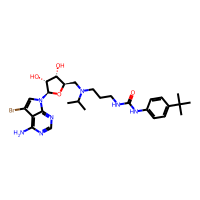
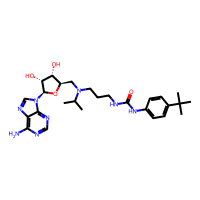
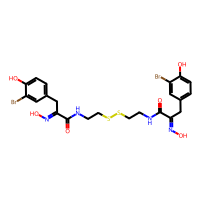

In [63]:
data = data[["molecule_chembl_id", "smiles", "label"]]
data["mol"] = data["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
data.head(3)

In [64]:
# Compute descriptors

# maccs_fp = pd.DataFrame([list(fp) for fp in data["mol"].apply(lambda x: Chem.rdMolDescriptors.GetMACCSKeysFingerprint(x))])
morgan_fp = pd.DataFrame([fp for fp in data["mol"].apply(lambda x: [int(y) for y in AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048).ToBitString()])])
rdk_fp = pd.DataFrame([fp for fp in data["mol"].apply(lambda x: [int(y) for y in Chem.RDKFingerprint(x, maxPath=7, fpSize=2048).ToBitString()])])

# print(maccs_fp.shape)
print(morgan_fp.shape)
print(rdk_fp.shape)

(228, 2048)
(228, 2048)


In [65]:
# Data partition

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, stratify=data["label"])
train_index = train_set.index
test_index = test_set.index

train_set = train_set.copy()
test_set = test_set.copy()

In [66]:
# Define models and hyperparameters to optimize

# To build all the combinations
# models = [{"Name":"k-NN", "Model":KNeighborsClassifier(n_jobs=-1), "Hyperparameters":{'n_neighbors': [1, 3, 5, 7, 9], 'metric': ['jaccard']}},
#           {"Name":"RF", "Model":RandomForestClassifier(n_jobs=-1, random_state=1590), "Hyperparameters":{'n_estimators': [1000], 'max_features': [1, 2, 3, 4, 5]}},
#           {"Name":"GBT", "Model":GradientBoostingClassifier(random_state=1590), "Hyperparameters":{'n_estimators': [1000], 'max_features': [1, 2, 3, 4, 5], 'max_depth': [4,5,6,7,8,9], 'min_samples_split': [2, 3, 4, 5]}},
#           {"Name":"SVM", "Model":SVC(random_state=1590), "Hyperparameters":{'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'kernel': ['linear', 'rbf', 'sigmoid'], 'probability': [True]}},
#           {"Name":"FFNN", "Model":MLPClassifier(random_state=1590), "Hyperparameters":{'solver': ['lbfgs'], 'max_iter': [10000], 'hidden_layer_sizes': [(8,), (16,)], 'activation': ['logistic', 'tanh', 'relu']}}
#           ]

# To build the best models reported in the manuscript
models = [{"Name":"SVM", "Model":SVC(random_state=1590), "Hyperparameters":{'C': [1.0], 'kernel': ['rbf'], 'probability': [True]}},
          {"Name":"FFNN", "Model":MLPClassifier(random_state=1590), "Hyperparameters":{'solver': ['lbfgs'], 'max_iter': [10000], 'hidden_layer_sizes': [(16,)], 'activation': ['tanh']}}
          ]
models

[{'Name': 'SVM',
  'Model': SVC(random_state=1590),
  'Hyperparameters': {'C': [1.0], 'kernel': ['rbf'], 'probability': [True]}},
 {'Name': 'FFNN',
  'Model': MLPClassifier(random_state=1590),
  'Hyperparameters': {'solver': ['lbfgs'],
   'max_iter': [10000],
   'hidden_layer_sizes': [(16,)],
   'activation': ['tanh']}}]

In [67]:
# LOO-CV

final_results = []

# For all combinations

# for model in tqdm(models):
#     loo = LeaveOneOut()
#     grid_search = GridSearchCV(estimator=model["Model"], param_grid=model["Hyperparameters"], cv=loo, scoring='balanced_accuracy', n_jobs=-1, refit=True)
#     grid_search.fit(maccs_fp.iloc[train_index], data.iloc[train_index]["label"])
#     loo_results = pd.DataFrame(grid_search.cv_results_)
#     best = loo_results[loo_results["rank_test_score"] == 1].head(1).copy()
#     best["Name"] = model["Name"]
#     best["FP"] = "MACCS"
#     final_results.append(best)
#     final_name = "{} + MACCS".format(model["Name"])
#     test_set[final_name] = list(grid_search.predict(maccs_fp.iloc[test_index]))

#     loo = LeaveOneOut()
#     grid_search = GridSearchCV(estimator=model["Model"], param_grid=model["Hyperparameters"], cv=loo, scoring='balanced_accuracy', n_jobs=-1, refit=True)
#     grid_search.fit(morgan_fp.iloc[train_index], data.iloc[train_index]["label"])
#     loo_results = pd.DataFrame(grid_search.cv_results_)
#     best = loo_results[loo_results["rank_test_score"] == 1].head(1).copy()
#     best["Name"] = model["Name"]
#     best["FP"] = "Morgan"
#     final_results.append(best)
#     final_name = "{} + Morgan".format(model["Name"])
#     test_set[final_name] = list(grid_search.predict(morgan_fp.iloc[test_index]))

#     loo = LeaveOneOut()
#     grid_search = GridSearchCV(estimator=model["Model"], param_grid=model["Hyperparameters"], cv=loo, scoring='balanced_accuracy', n_jobs=-1, refit=True)
#     grid_search.fit(rdk_fp.iloc[train_index], data.iloc[train_index]["label"])
#     loo_results = pd.DataFrame(grid_search.cv_results_)
#     best = loo_results[loo_results["rank_test_score"] == 1].head(1).copy()
#     best["Name"] = model["Name"]
#     best["FP"] = "RDK"
#     final_results.append(best)
#     final_name = "{} + RDK".format(model["Name"])
#     test_set[final_name] = list(grid_search.predict(rdk_fp.iloc[test_index]))

# For the best models reported in the manuscript

loo = LeaveOneOut()
grid_search = GridSearchCV(estimator=models[0]["Model"], param_grid=models[0]["Hyperparameters"], cv=loo, scoring='balanced_accuracy', n_jobs=-1, refit=True)
grid_search.fit(rdk_fp.iloc[train_index], data.iloc[train_index]["label"])
loo_results = pd.DataFrame(grid_search.cv_results_)
best = loo_results[loo_results["rank_test_score"] == 1].head(1).copy()
best["Name"] = models[0]["Name"]
best["FP"] = "RDK"
final_results.append(best)
final_name = "{} + RDK".format(models[0]["Name"])
test_set[final_name] = list(grid_search.predict(rdk_fp.iloc[test_index]))

grid_search = GridSearchCV(estimator=models[1]["Model"], param_grid=models[1]["Hyperparameters"], cv=loo, scoring='balanced_accuracy', n_jobs=-1, refit=True)
grid_search.fit(morgan_fp.iloc[train_index], data.iloc[train_index]["label"])
loo_results = pd.DataFrame(grid_search.cv_results_)
best = loo_results[loo_results["rank_test_score"] == 1].head(1).copy()
best["Name"] = models[1]["Name"]
best["FP"] = "Morgan"
final_results.append(best)
final_name = "{} + Morgan".format(models[1]["Name"])
test_set[final_name] = list(grid_search.predict(morgan_fp.iloc[test_index]))



In [71]:
# Custom function to obtain labels from BA results
def get_prediction(true_label, bal_acc):
    if bal_acc == 1:
        return true_label
    else:
        if true_label == 0:
            return 1
        else:
            return 0

In [72]:
# Summary results

for result in final_results:
    moldel_name = result["Name"].iloc[0]
    model_fp = result["FP"].iloc[0]
    final_name = "{} + {}".format(moldel_name, model_fp)

    true_y_train = train_set.copy()
    true_y_train["ba_loo"] = list(x for x in result[["split{}_test_score".format(x) for x in range(train_set.shape[0])]].reset_index(drop=True).transpose()[0])
    train_set[final_name] = true_y_train.apply(lambda row: get_prediction(row["label"], row["ba_loo"]), axis=1)

    ba = balanced_accuracy_score(y_true=true_y_train["label"], y_pred=train_set[final_name])

    result["BA"] = ba
    result["Final Name"] = final_name

summary = pd.concat([result[["Name", "FP", "params", "BA", "Final Name"]] for result in final_results]).sort_values("BA", ascending=False).reset_index(drop=True)
summary["BA_Test"] = [balanced_accuracy_score(y_true=test_set["label"], y_pred=test_set[final_name]) for final_name in summary["Final Name"]]
summary

,Name,FP,params,BA,Final Name,BA_Test
0,SVM,RDK,"{'C': 1.0, 'kernel': 'rbf', 'probability': True}",0.819738,SVM + RDK,0.875000
1,FFNN,Morgan,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.785494,FFNN + Morgan,0.753968


<Axes: >

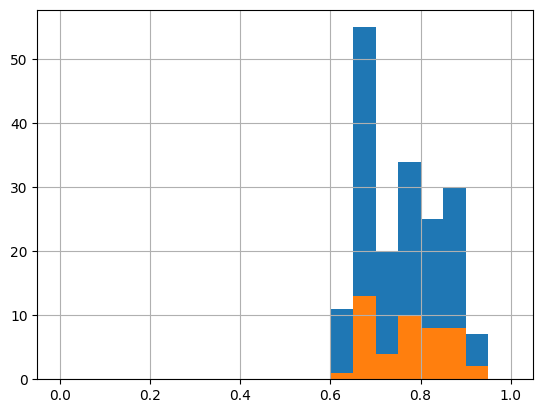

In [73]:
# Distance-To-Model
dtm_train = pd.DataFrame(squareform(pdist(morgan_fp.iloc[train_index], metric="jaccard"))).sum(axis=1)/morgan_fp.iloc[train_index].shape[0]
dtm_train.hist(bins=[x*0.05 for x in range(0,21)])

dtm_test = pd.DataFrame(cdist(morgan_fp.iloc[test_index], morgan_fp.iloc[train_index], metric="jaccard")).mean(axis=1)
dtm_test.hist(bins=[x*0.05 for x in range(0,21)])

In [74]:
train_set["DTM"] = list(dtm_train)
train_set["DTM"].describe(percentiles=[0.25,0.75])

count    182.000000
mean       0.759421
std        0.082847
min        0.612753
25%        0.679925
50%        0.777949
75%        0.817690
max        0.933431
Name: DTM, dtype: float64

In [75]:
# Custom function to asign a quartile according to the mean jaccard distance
def get_quartile(dtm):
    if dtm <= train_set["DTM"].describe(percentiles=[0.25,0.75])["25%"]:
        return "Q1"
    elif dtm <= train_set["DTM"].describe(percentiles=[0.25,0.75])["50%"] and dtm > train_set["DTM"].describe(percentiles=[0.25,0.75])["25%"]:
        return "Q2"
    elif dtm <= train_set["DTM"].describe(percentiles=[0.25,0.75])["75%"] and dtm > train_set["DTM"].describe(percentiles=[0.25,0.75])["50%"]:
        return "Q3"
    elif dtm <= train_set["DTM"].describe(percentiles=[0.25,0.75])["max"] and dtm > train_set["DTM"].describe(percentiles=[0.25,0.75])["75%"]:
        return "Q4"
    else:
        return "Out"

In [76]:
train_set["Quartile"] = train_set["DTM"].apply(get_quartile)

In [77]:
# Distance-to-model results for the training set

dtm_results = []
for name, group in train_set.groupby("Quartile"):
    for model in list(train_set[['SVM + RDK', 'FFNN + Morgan']]):
        dtm_results.append([model, name, group.shape[0], precision_score(y_pred=group[model], y_true=group["label"]), recall_score(y_pred=group[model], y_true=group["label"])])

dtm_results = pd.DataFrame(dtm_results, columns=["Name", "Quartile", "Size", "Precision", "Recall"])
dtm_results

,Name,Quartile,Size,Precision,Recall
0,SVM + RDK,Q1,46,0.978261,1.000000
1,FFNN + Morgan,Q1,46,0.978261,1.000000
2,SVM + RDK,Q2,45,0.926829,0.950000
3,FFNN + Morgan,Q2,45,0.900000,0.900000
4,SVM + RDK,Q3,45,0.428571,0.157895
5,FFNN + Morgan,Q3,45,0.526316,0.526316
6,SVM + RDK,Q4,46,0.500000,0.111111
7,FFNN + Morgan,Q4,46,0.428571,0.333333


In [78]:
# Distance-to-model results for the test set

test_set["DTM"] = list(dtm_test)
test_set["Quartile"] = test_set["DTM"].apply(get_quartile)

dtm_results_test = []
for name, group in test_set.groupby("Quartile"):
    for model in list(train_set[['SVM + RDK', 'FFNN + Morgan']]):
        dtm_results_test.append([model, name, group.shape[0], precision_score(y_pred=group[model], y_true=group["label"]), recall_score(y_pred=group[model], y_true=group["label"])])

dtm_results_test = pd.DataFrame(dtm_results_test, columns=["Name", "Quartile", "Size", "Precision", "Recall"])
dtm_results_test

,Name,Quartile,Size,Precision,Recall
0,SVM + RDK,Q1,12,1.0,1.000000
1,FFNN + Morgan,Q1,12,1.0,1.000000
2,SVM + RDK,Q2,6,1.0,1.000000
3,FFNN + Morgan,Q2,6,1.0,0.833333
4,SVM + RDK,Q3,15,1.0,0.333333
5,FFNN + Morgan,Q3,15,0.5,0.666667
6,SVM + RDK,Q4,13,1.0,0.250000
7,FFNN + Morgan,Q4,13,0.5,0.250000


In [44]:
# Training of final models

rdk_model = SVC(C= 1.0, kernel= 'rbf', probability=True, random_state=1590)
morgan_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(16,), max_iter=10000, solver='lbfgs', random_state=1590)

rdk_model.fit(rdk_fp, data["label"])
morgan_model.fit(morgan_fp, data["label"])

MLPClassifier(activation='tanh', hidden_layer_sizes=(16,), max_iter=10000,
              random_state=1590, solver='lbfgs')

In [79]:
# Specify the PATH to the De Novo libraries (or any external library)
denovo_compounds = pd.read_csv("/content/DeNovo_DNMT1_8066.csv")
denovo_compounds.head()

,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE,SMILES_chiral,SMILES_no_chiral
0,OCCCNC(=O)c1cc(nc2cc(n[n]12)C(F)(F)F)-c1ccco1,AB_CDDNMT,ABCDT01_01,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1.0,O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12,O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12
1,CC(O)C(=O)OCN=C1NC(=Nc2ccccc12)c1cc(ccc1Br)OC(...,AB_CDDNMT,ABCDT01_02,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1.0,CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...,CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...
2,CN=C1N=C(NC2=C1C(=O)CC(F)(C2)N1CCN(CC1)C(C)=O)...,AB_CDDNMT,ABCDT01_03,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1.0,CN=c1[nH]c(-c2ccccc2)nc2c1C(=O)CC(F)(N1CCN(C(C...,CN=c1[nH]c(-c2ccccc2)nc2c1C(=O)CC(F)(N1CCN(C(C...
3,Clc1ccc(cc1)C1=Nc2ccccc2C(N1)=NCCCCCCOC=O,AB_CDDNMT,ABCDT01_04,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1.0,O=COCCCCCCN=c1[nH]c(-c2ccc(Cl)cc2)nc2ccccc12,O=COCCCCCCN=c1[nH]c(-c2ccc(Cl)cc2)nc2ccccc12
4,CC(=O)NCC=CN1C(NN=C1c1ccccc1)=NCCCCCCOC=O,AB_CDDNMT,ABCDT01_05,AlvaBuilder,ChemDiv DNMT,AB_CDDNMT01,1.0,CC(=O)NCC=Cn1c(-c2ccccc2)n[nH]c1=NCCCCCCOC=O,CC(=O)NCC=Cn1c(-c2ccccc2)n[nH]c1=NCCCCCCOC=O


In [ ]:
# Build mol objects
denovo_compounds["mol"] = denovo_compounds["SMILES_chiral"].apply(lambda x: Chem.MolFromSmiles(x))

# Compute fingerprints
ext_morgan_fp = pd.DataFrame([fp for fp in denovo_compounds["mol"].apply(lambda x: [int(y) for y in AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048).ToBitString()])])
ext_rdk_fp = pd.DataFrame([fp for fp in denovo_compounds["mol"].apply(lambda x: [int(y) for y in Chem.RDKFingerprint(x, maxPath=7, fpSize=2048).ToBitString()])])

# Obtain Distance-to-model quartiles

ext_dtm = pd.DataFrame(cdist(ext_morgan_fp, morgan_fp, metric="jaccard")).mean(axis=1)
denovo_compounds["DTM"] = list(ext_dtm)
denovo_compounds["Quartile"] = denovo_compounds["DTM"].apply(get_quartile)

# Perform predictions

denovo_compounds["SVM + RDK"] = rdk_model.predict(ext_rdk_fp)
denovo_compounds["FFNN + Morgan"] = morgan_model.predict(ext_morgan_fp)


In [ ]:
# Focus on compounds predicted as actives
rdk_actives  = denovo_compounds[denovo_compounds["SVM + RDK"] == 1].reset_index(drop=True)
morgan_actives = denovo_compounds[denovo_compounds["FFNN + Morgan"] == 1].reset_index(drop=True)

In [52]:
# Summary results for SVM + RDK model
rdk_counts = pd.DataFrame(rdk_actives.groupby(["DATABASE", "Quartile"])["SVM + RDK"].value_counts())
rdk_counts

count
DATABASE Quartile SVM + RDK       
AB_DNMT1 Q2       1              1
         Q3       1              6
         Q4       1              8

In [53]:
# Summary results for FFNN + Morgan model
morgan_counts = pd.DataFrame(morgan_actives.groupby(["DATABASE", "Quartile"])["FFNN + Morgan"].value_counts())
morgan_counts

count
DATABASE  Quartile FFNN + Morgan       
AB_CDDNMT Out      1                  1
          Q4       1                137
AB_CDEPI  Q4       1                125
AB_CDSOL  Out      1                  1
          Q4       1                116
AB_DNMT1  Q2       1                  1
          Q3       1                 16
          Q4       1                168
AB_FOODB  Out      1                 21
          Q4       1                108
AB_LCDIV  Q4       1                139
AB_LCEPI  Q4       1                127
AB_UNPDA  Out      1                 66
          Q4       1                142
LB_CDEPF  Q4       1                 15
LB_CDFRG  Q4       1                  4
LB_CDFSO  Q4       1                  5
LB_DEFLT  Q4       1                 15
LB_DNMT1  Q4       1                 34
LB_FOODB  Q4       1                  8
LB_SELFR  Q4       1                  9
LB_UNPDA  Q4       1                  6

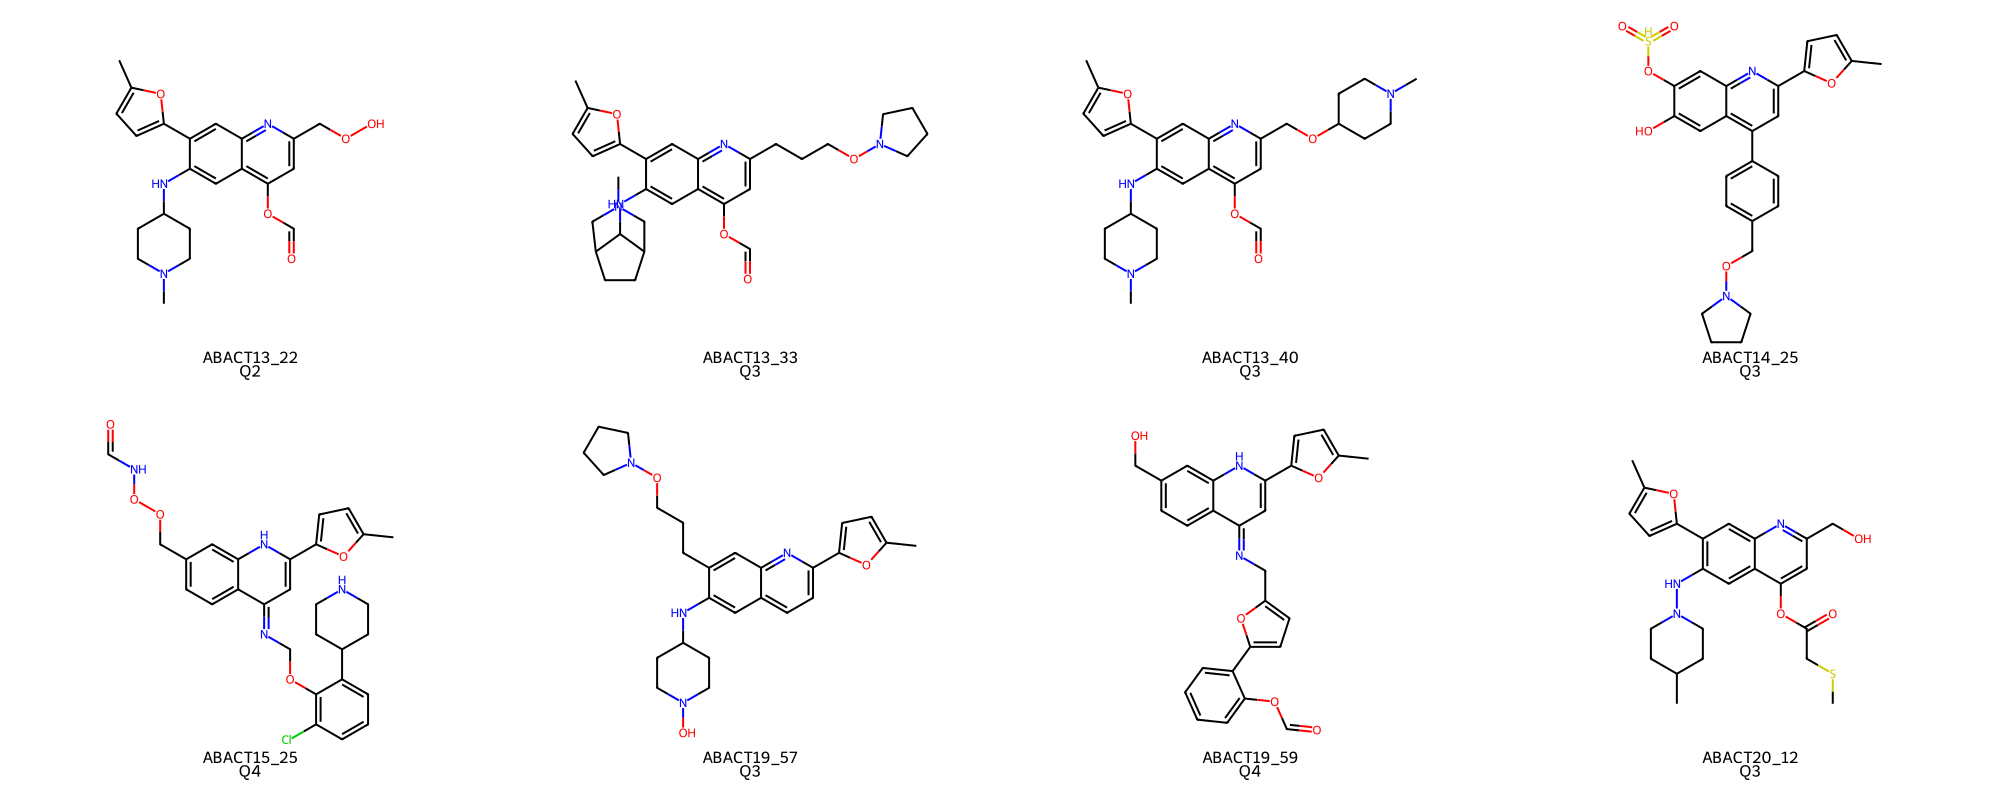

In [55]:
# Compounds predicted as active by the two models

both_actives = denovo_compounds[(denovo_compounds["SVM + RDK"] == 1) & (denovo_compounds["FFNN + Morgan"] == 1)].reset_index(drop=True)
both_actives = both_actives.copy()
both_actives["New_ID"] = ["{}\n{}".format(row["ID"], row["Quartile"]) for index, row in both_actives.iterrows()]

quinoline = Chem.MolFromSmiles("C1=CC=C2C(=C1)C=CC=N2")

AllChem.Compute2DCoords(quinoline)
for query in both_actives["mol"]:
    AllChem.GenerateDepictionMatching2DStructure(query, quinoline)

Chem.Draw.MolsToGridImage(both_actives["mol"], legends =list(both_actives["New_ID"]), molsPerRow=4, subImgSize=(500,400))

In [ ]:
# Results can be easily exported
# denovo_compounds.to_csv("/content/DeNovo_DNMT1_8066_Pred.csv")